In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
#url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:14<00:00, 99.9MB/s]


In [ ]:
filenames_list = []
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'

for filename in sorted(os.listdir(dataset_dir)):
    filenames_list.append(dataset_dir + filename)

filenames_list = filenames_list[:100000]
print(len(filenames_list))

100000


In [ ]:
filenames_list[0]

'data/celeba/img_align_celeba/img_align_celeba/000001.jpg'

In [ ]:
#Colourization class
import numpy as np
from tensorflow.keras.utils import Sequence

from skimage import io, color
from skimage.transform import resize
from matplotlib import pyplot as plt

img_size = 128

class Generator(Sequence):

    def __init__(self, filenames_list, batch_size, img_size):
        self.filenames_list = filenames_list
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.filenames_list) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.filenames_list[idx * self.batch_size:(idx + 1) * self.batch_size]

        input_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)
        output_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 2), dtype=np.float32)

        i = 0
        for filename in batch_x:

            read_image = io.imread(filename)

            image = resize(read_image, (self.img_size, self.img_size), anti_aliasing=False, mode='constant')


            if image.shape == (self.img_size, self.img_size, 3) :
               try:
                    if not ((image[:, :, 0] == image[:, :, 1]).all()) \
                            or not ((image[:, :, 1] == image[:, :, 2]).all()):  # if not a BW image

                        image = color.rgb2lab(image)
                        # array image for output tensor
                        output_tensor[i, :] = (image[:, :, 1:] / 128)
                        # array values for input tensor
                        input_tensor[i, :] = (image[:, :, 0] / 100).reshape(img_size, img_size, 1)
                        i += 1
               except:
                    print(image.shape)
                    io.imshow(image)
                    plt.show()

        return input_tensor, output_tensor

In [ ]:
import os
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, ZeroPadding2D, Concatenate
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 14 04:14:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Root directory for the logs
log_root = f'{data_root}/logs'
# Path to folder with the dataset
weights_root = f'{data_root}//weights'

# Create required directories 
if not os.path.exists(log_root):
  os.makedirs(log_root)
  os.makedirs(weights_root)

In [ ]:
img_size = 128
batch_size = 64

training_batch_generator = Generator(filenames_list=filenames_list, batch_size=batch_size, img_size=img_size)

tensorboard = TensorBoard(log_dir=log_root+"/{}".format(time()))

# model

input_layer = Input(shape=(img_size, img_size, 1))

hidden_layer_1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_layer)
hidden_layer_1 = BatchNormalization()(hidden_layer_1)
hidden_layer_2 = Conv2D(64, (5, 5), activation='relu',  padding='same')(hidden_layer_1)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(hidden_layer_2)
hidden_layer_3 = BatchNormalization()(hidden_layer_3)
hidden_layer_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(hidden_layer_3)
hidden_layer_4 = BatchNormalization()(hidden_layer_4)
hidden_layer_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(hidden_layer_4)
hidden_layer_5 = BatchNormalization()(hidden_layer_5)

output_layer = Conv2D(2, (3, 3), activation='tanh', padding='same')(hidden_layer_5)

model = Model(inputs=input_layer, outputs=output_layer)

opt = tensorflow.keras.optimizers.RMSprop()

model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
#plot_model(model, to_file='test_logs/cnn/cnn_model.png')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      1600      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
1563/1563 [==============================] - 1139s 713ms/step - loss: 0.0162 - accuracy: 0.5751
Epoch 2/10
1563/1563 [==============================] - 1041s 663ms/step - loss: 0.0081 - accuracy: 0.6183
Epoch 3/10
1563/1563 [==============================] - 1041s 663ms/step - loss: 0.0077 - accuracy: 0.6208
Epoch 4/10
1563/1563 [==============================] - 1038s 661ms/step - loss: 0.0076 - accuracy: 0.6252
Epoch 5/10
1563/1563 [==============================] - 1047s 667ms/step - loss: 0.0075 - accuracy: 0.6278
Epoch 6/10
1563/1563 [==============================] - 1057s 673ms/step - loss: 0.0074 - accuracy: 0.6304
Epoch 7/10
1563/1563 [==============================] - 1063s 676ms/step - loss: 0.0074 - accuracy: 0.6329
Epoch 8/10
1563/1563 [==============================] - 1065s 678ms/step - loss: 0.0074 - accuracy: 0.6338
Epoch 9/10
1563/1563 [==============================] - 1069s 680ms/step - loss: 0.0073 - accuracy: 0.6347
Epoch 10/10
1563/1563 [==============

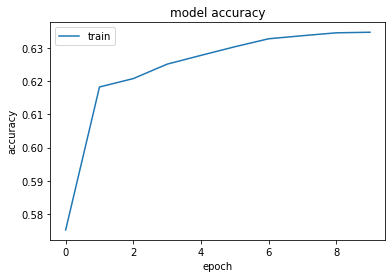

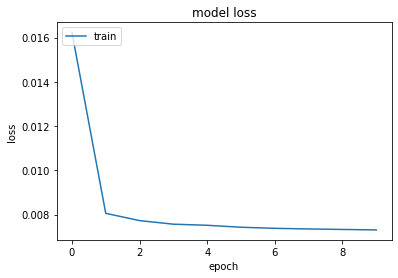

In [ ]:
with tf.device("/gpu:0"):
   history = model.fit_generator(training_batch_generator, epochs=10, verbose=1, use_multiprocessing=True,workers=8)
   #history = model.fit(training_batch_generator, epochs=10, verbose=1,workers=8)

   print(history.history.keys())
   # summarize history for accuracy
   plt.plot(history.history['accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/accuracy_plot.png")
   plt.show()
   # summarize history for loss
   plt.plot(history.history['loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/loss_plot.png")
   plt.show()

model.save(weights_root+"/CNNs.h5")

In [ ]:
import numpy as np
import os
from keras.models import load_model
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import pandas as pd


In [ ]:
img_size = 128
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'


def ret_input_output_tensor(dataset_dir, n_images):
    input_tensor = np.empty((n_images, img_size, img_size, 1))
    output_tensor = np.empty((n_images, img_size, img_size, 2))

    i = 0
    print(len(os.listdir(dataset_dir)))
    for filename in reversed(sorted(os.listdir(dataset_dir))):

        if filename.endswith('.jpg'):

            image = io.imread(dataset_dir + filename)
            image = resize(image, (img_size, img_size, 3), anti_aliasing=False, mode='constant')
            image = color.rgb2lab(image)

            if image.shape == (img_size, img_size, 3):  # if not a BW image
                # array image for output tensor
                output_tensor[i, :] = (image[:, :, 1:] / 128)
                # array values for input tensor
                input_tensor[i, :] = (image[:, :, 0] / 100).reshape(img_size, img_size, 1)
                i += 1

        if i >= n_images: break

    return input_tensor, output_tensor


In [ ]:
print(os.listdir())
model = load_model("/content/data/CNNs.h5")

# prediction

input_tensor, output_tensor = ret_input_output_tensor(dataset_dir, 10)

prediction = model.predict(input_tensor)

['.config', 'data', 'sample_data']
202599


input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.01068121  0.02037526]
  [ 0.01910144  0.01864247]
  [ 0.00979423  0.01842065]
  ...
  [-0.00117064  0.00489698]
  [ 0.02092747  0.01331248]
  [ 0.02019455  0.00017103]]

 [[-0.01505339  0.00540071]
  [ 0.00470944  0.01185976]
  [ 0.00282248  0.01979611]
  ...
  [-0.00492963  0.018257  ]
  [ 0.00671771  0.02149736]
  [ 0.00818946  0.03240447]]

 [[ 0.00347164  0.02741067]
  [-0.00181943  0.01779507]
  [-0.00390457  0.02032149]
  ...
  [-0.01412431  0.01551157]
  [-0.00985295  0.01146546]
  [-0.0131355   0.00428487]]

 ...

 [[-0.00245492  0.02559579]
  [ 0.00139734  0.01341092]
  [-0.00292091  0.01222003]
  ...
  [ 0.12485948  0.12054143]
  [ 0.12847659  0.11177278]
  [ 0.0887325   0.08876212]]

 [[ 0.00042112  0.02584162]
  [ 0.01055556  0.02425354]
  [-0.00774231  0.01305939]
  ...
  [ 0.11739232  0.12344954]
  [ 0.12115562  0.10840674]
  [ 0.08084973  0.08639289]]

 [[ 0.01834736  0.04602574]
  [ 0.0223422   0.0215077 ]
  [ 0.00313821

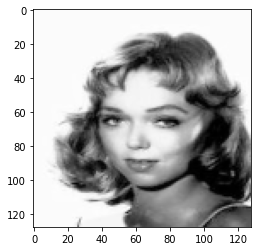

(128, 128, 3)


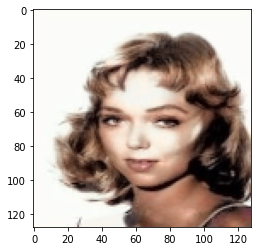

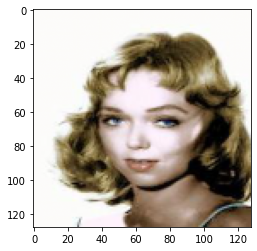

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.03048659  0.03196277]
  [ 0.05399696  0.03348891]
  [ 0.05434204  0.03616746]
  ...
  [ 0.05533236  0.03917242]
  [ 0.06100647  0.03729053]
  [ 0.04473018  0.02218899]]

 [[ 0.02470111  0.0190549 ]
  [ 0.05161631  0.03114832]
  [ 0.05986967  0.03865254]
  ...
  [ 0.05477501  0.04649776]
  [ 0.05121832  0.03916591]
  [ 0.0475065   0.05860243]]

 [[ 0.05325599  0.05002068]
  [ 0.06211839  0.04858302]
  [ 0.06405941  0.0480204 ]
  ...
  [ 0.05182549  0.04962332]
  [ 0.04759367  0.04401088]
  [ 0.03610818  0.04591669]]

 ...

 [[ 0.04039685  0.03765691]
  [ 0.0446488   0.02945154]
  [ 0.03805718  0.01665604]
  ...
  [ 0.0153027   0.00092673]
  [ 0.02002111  0.00308596]
  [ 0.02030382  0.00666573]]

 [[ 0.03780419  0.03322916]
  [ 0.04831435  0.03301708]
  [ 0.03492197  0.01909483]
  ...
  [ 0.02249451  0.00230012]
  [ 0.02797724 -0.00059505]
  [ 0.01610898  0.00474154]]

 [[ 0.03726371  0.04075639]
  [ 0.04121261  0.02745569]
  [ 0.0318499 

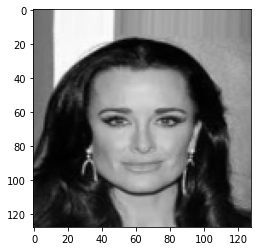

(128, 128, 3)


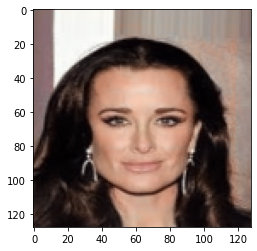

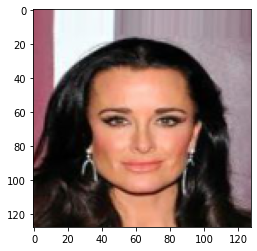

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.0243631   0.02762401]
  [ 0.04666033  0.02812948]
  [ 0.04391465  0.02857862]
  ...
  [ 0.06491872  0.02845883]
  [ 0.06851044  0.0293398 ]
  [ 0.04882937  0.01588548]]

 [[ 0.01679897  0.01661052]
  [ 0.04242812  0.02779459]
  [ 0.04734188  0.0317944 ]
  ...
  [ 0.0639345   0.02209154]
  [ 0.05994144  0.02063127]
  [ 0.04685795  0.04309676]]

 [[ 0.04257922  0.04279717]
  [ 0.04899249  0.03818697]
  [ 0.05031625  0.03123831]
  ...
  [ 0.07025275  0.03330217]
  [ 0.06417808  0.0279647 ]
  [ 0.04168747  0.02710435]]

 ...

 [[ 0.02962227  0.00607197]
  [ 0.03467305 -0.00362579]
  [ 0.02578914 -0.01312356]
  ...
  [ 0.06443518  0.04062357]
  [ 0.06533945  0.04026628]
  [ 0.05291973  0.04527783]]

 [[ 0.02390795  0.00245624]
  [ 0.04370558 -0.00296389]
  [ 0.02577468 -0.01835906]
  ...
  [ 0.05643227  0.02340669]
  [ 0.05966927  0.02535215]
  [ 0.04671056  0.03547062]]

 [[ 0.02151941  0.0129468 ]
  [ 0.02677228 -0.01179765]
  [ 0.01938824

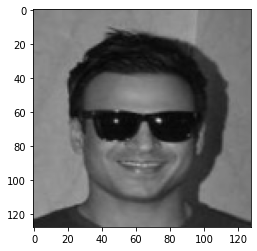

(128, 128, 3)


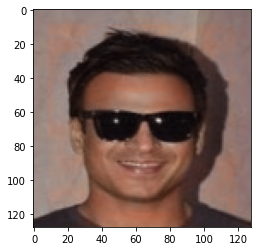

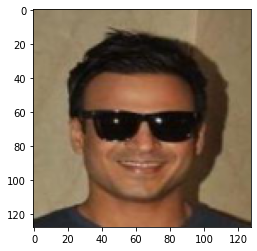

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.02406446  0.0123704 ]
  [ 0.03913107  0.00944047]
  [ 0.03329002  0.00563736]
  ...
  [ 0.04598333  0.04428828]
  [ 0.05712591  0.04240484]
  [ 0.0439505   0.02370963]]

 [[ 0.00432929 -0.00890415]
  [ 0.02954285 -0.00077315]
  [ 0.02711857  0.00231637]
  ...
  [ 0.04460036  0.04965812]
  [ 0.05082102  0.04563854]
  [ 0.05129676  0.06581268]]

 [[ 0.02582262  0.01260699]
  [ 0.02533041  0.00765768]
  [ 0.0196902   0.00365941]
  ...
  [ 0.04111013  0.06300603]
  [ 0.040526    0.05817761]
  [ 0.03785134  0.05731414]]

 ...

 [[ 0.03738225  0.0231929 ]
  [ 0.044285    0.03697583]
  [ 0.03676352  0.04383981]
  ...
  [ 0.04381971  0.00393534]
  [ 0.05119476  0.00384446]
  [ 0.04169833  0.01582948]]

 [[ 0.03530527  0.02586586]
  [ 0.04808567  0.04189506]
  [ 0.02673904  0.03844403]
  ...
  [ 0.04147601  0.00811725]
  [ 0.04619924  0.00737141]
  [ 0.03928833  0.01999149]]

 [[ 0.03807324  0.04500931]
  [ 0.04534497  0.04796191]
  [ 0.03298604

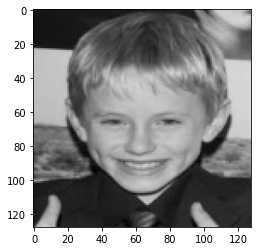

(128, 128, 3)


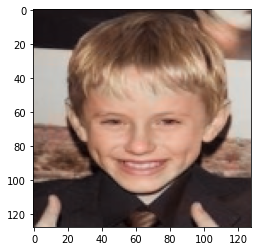

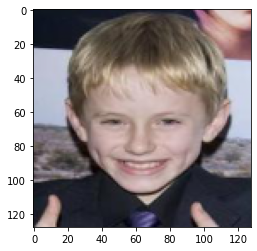

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.01154999  0.01938657]
  [ 0.01986046  0.02012013]
  [ 0.00754482  0.02215124]
  ...
  [ 0.00134757  0.01771984]
  [ 0.02136753  0.02215724]
  [ 0.01816966  0.00702889]]

 [[-0.01232537  0.00943116]
  [ 0.00762937  0.01706264]
  [ 0.00647661  0.02252089]
  ...
  [-0.00341255  0.02545312]
  [ 0.00571953  0.02531569]
  [ 0.00924099  0.04063154]]

 [[ 0.00451016  0.03267698]
  [-0.00138456  0.02444749]
  [-0.00429007  0.02461234]
  ...
  [-0.00677618  0.02538393]
  [-0.00378325  0.01941612]
  [-0.00929134  0.01410776]]

 ...

 [[ 0.00909957  0.04901109]
  [ 0.00257782  0.03976235]
  [-0.0049727   0.03708272]
  ...
  [ 0.01577312  0.07302272]
  [ 0.0197497   0.05398924]
  [ 0.01715446  0.05103642]]

 [[ 0.01405423  0.04972545]
  [ 0.02333719  0.05470702]
  [ 0.00459118  0.04739683]
  ...
  [ 0.03503603  0.07974456]
  [ 0.03185448  0.05468103]
  [ 0.01946964  0.04612639]]

 [[ 0.0298357   0.06364873]
  [ 0.03286013  0.04968898]
  [ 0.01755069

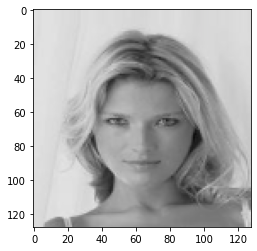

(128, 128, 3)


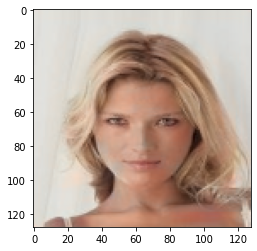

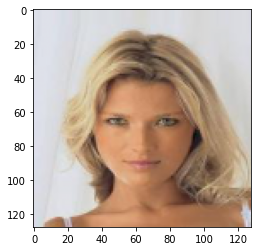

input tensor :
 (128, 128, 1)
prediction :
 [[[ 1.34991761e-02  2.19319463e-02]
  [ 2.23337654e-02  2.48423479e-02]
  [ 1.00593921e-02  2.62599271e-02]
  ...
  [ 3.49361496e-03  1.33911129e-02]
  [ 1.51721975e-02  2.15970054e-02]
  [ 1.94348283e-02  9.65748541e-03]]

 [[-4.72632609e-03  1.08998828e-02]
  [ 1.31820310e-02  2.38637924e-02]
  [ 1.22997388e-02  2.96928100e-02]
  ...
  [-1.08058564e-02  1.03933411e-02]
  [ 5.20552415e-03  2.26268508e-02]
  [ 1.09947128e-02  4.38803323e-02]]

 [[ 1.13728503e-02  3.96702550e-02]
  [ 8.34563281e-03  3.58330496e-02]
  [ 2.79089063e-03  3.33471894e-02]
  ...
  [-1.52819250e-02  8.27541202e-03]
  [-5.58469538e-03  1.05759194e-02]
  [-8.50563031e-03  1.12692844e-02]]

 ...

 [[ 7.85052925e-02  7.79745802e-02]
  [ 8.01896527e-02  8.62185955e-02]
  [ 8.37784410e-02  1.00195020e-01]
  ...
  [-3.09161842e-05  1.93151552e-02]
  [-6.47544744e-04  7.52587570e-03]
  [ 1.16720209e-02  2.33097486e-02]]

 [[ 7.45945573e-02  7.29155093e-02]
  [ 9.30906385e-02

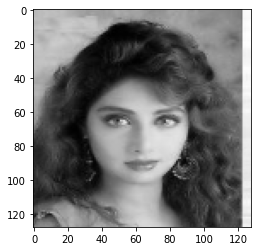

(128, 128, 3)


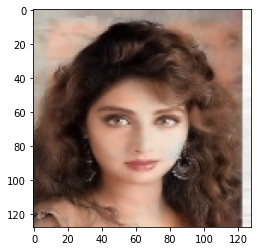

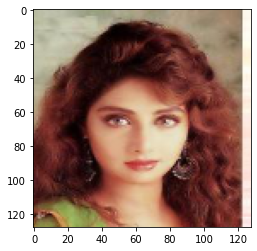

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.01098094  0.01952021]
  [ 0.01953445  0.01893258]
  [ 0.00850754  0.01952591]
  ...
  [-0.00127661  0.00642965]
  [ 0.02081308  0.01428438]
  [ 0.01953421  0.00055014]]

 [[-0.01420078  0.00718632]
  [ 0.00663968  0.01470577]
  [ 0.00454191  0.02119706]
  ...
  [-0.00505773  0.01929148]
  [ 0.0068856   0.02230416]
  [ 0.00795123  0.03291525]]

 [[ 0.00340047  0.02908411]
  [-0.00157523  0.02085808]
  [-0.00406532  0.02081096]
  ...
  [-0.01327693  0.01717062]
  [-0.00918456  0.01277698]
  [-0.01274703  0.00479267]]

 ...

 [[ 0.03206914  0.01646497]
  [ 0.03704425  0.00977515]
  [ 0.02783819  0.00875258]
  ...
  [ 0.10247349 -0.03069386]
  [ 0.10103758 -0.02303537]
  [ 0.08876906  0.01131911]]

 [[ 0.03256284  0.01483026]
  [ 0.04480282  0.0150951 ]
  [ 0.03280612  0.0106145 ]
  ...
  [ 0.07891078 -0.03552636]
  [ 0.08078416 -0.005277  ]
  [ 0.08392749  0.02713929]]

 [[ 0.03190766  0.02891764]
  [ 0.03891009  0.01526861]
  [ 0.0317705 

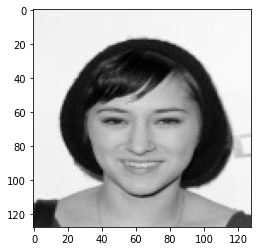

(128, 128, 3)


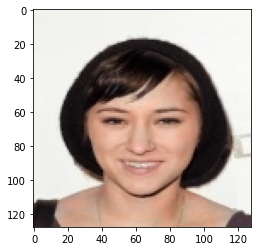

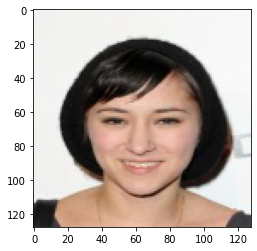

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.03396268  0.03989848]
  [ 0.05409429  0.0438518 ]
  [ 0.04967145  0.04759767]
  ...
  [ 0.03241745  0.00221893]
  [ 0.04631331  0.00851323]
  [ 0.0419299   0.00043755]]

 [[ 0.02828257  0.03143765]
  [ 0.05242276  0.04753383]
  [ 0.05626816  0.05821024]
  ...
  [ 0.03168609 -0.00035751]
  [ 0.04011278 -0.00074557]
  [ 0.04360243  0.02948617]]

 [[ 0.0565379   0.06575533]
  [ 0.05747427  0.06791361]
  [ 0.05556047  0.0745739 ]
  ...
  [ 0.01988992  0.00304192]
  [ 0.02572975  0.00113705]
  [ 0.02783443  0.0068729 ]]

 ...

 [[ 0.05396537  0.08047296]
  [ 0.04321925  0.08956309]
  [ 0.03769229  0.09824179]
  ...
  [ 0.07416219  0.07086607]
  [ 0.07491388  0.05967426]
  [ 0.04581823  0.03991685]]

 [[ 0.05707654  0.08124257]
  [ 0.06073137  0.09645241]
  [ 0.04586241  0.09625874]
  ...
  [ 0.07856779  0.07499868]
  [ 0.07918899  0.06219263]
  [ 0.04557622  0.04329836]]

 [[ 0.05627974  0.08291507]
  [ 0.06086005  0.0858148 ]
  [ 0.05344873

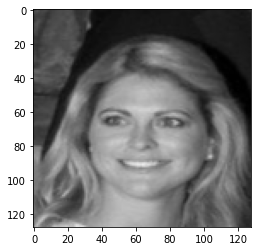

(128, 128, 3)


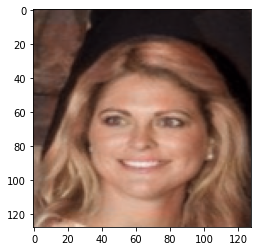

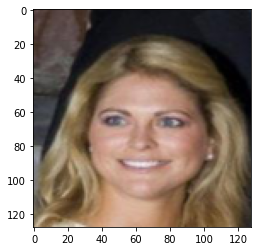

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.01146495  0.01920972]
  [ 0.01976554  0.0198356 ]
  [ 0.00746399  0.0214502 ]
  ...
  [-0.00043719  0.01400036]
  [ 0.0206853   0.01972832]
  [ 0.01795206  0.00424265]]

 [[-0.01260398  0.00950712]
  [ 0.00767701  0.01730153]
  [ 0.00577588  0.02227883]
  ...
  [-0.00467188  0.02379644]
  [ 0.00618601  0.02502019]
  [ 0.00771509  0.0369208 ]]

 [[ 0.00430502  0.03200535]
  [-0.00153553  0.02409679]
  [-0.00520187  0.02328242]
  ...
  [-0.00924402  0.02234365]
  [-0.00504247  0.01687162]
  [-0.01171803  0.00947394]]

 ...

 [[ 0.00572405  0.04013938]
  [-0.0002677   0.02675786]
  [-0.00378702  0.0272575 ]
  ...
  [-0.00079861  0.02979128]
  [ 0.00262622  0.02196779]
  [ 0.0102187   0.02651071]]

 [[ 0.006712    0.0394934 ]
  [ 0.01544952  0.0394465 ]
  [-0.00357538  0.03277746]
  ...
  [ 0.00133017  0.03127661]
  [ 0.0115824   0.01903109]
  [ 0.01280399  0.02403365]]

 [[ 0.02316505  0.05382499]
  [ 0.02342191  0.03210578]
  [ 0.00902554

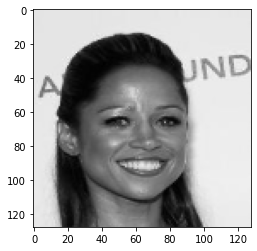

(128, 128, 3)


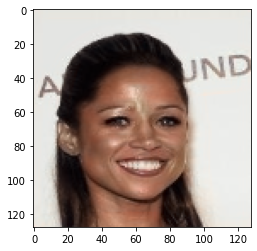

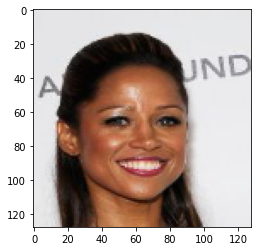

input tensor :
 (128, 128, 1)
prediction :
 [[[ 0.0223463   0.01560427]
  [ 0.03915561  0.01524978]
  [ 0.0327964   0.01364108]
  ...
  [ 0.01292096  0.00628518]
  [ 0.033624    0.01229033]
  [ 0.03112349 -0.00516497]]

 [[ 0.00062878 -0.01330399]
  [ 0.02423666 -0.0060842 ]
  [ 0.02057643 -0.00287591]
  ...
  [ 0.0145766   0.00294337]
  [ 0.02704418  0.00656912]
  [ 0.02707526  0.02626413]]

 [[ 0.02220199  0.01047683]
  [ 0.02593279  0.00793706]
  [ 0.01951235  0.00708731]
  ...
  [ 0.00212973  0.00249944]
  [ 0.013194    0.00553617]
  [ 0.00463571 -0.00106808]]

 ...

 [[ 0.03257645  0.00895073]
  [ 0.03528153  0.00777017]
  [ 0.02883397  0.0005023 ]
  ...
  [ 0.03480087  0.01170199]
  [ 0.03396944  0.00555539]
  [ 0.03180636  0.01755749]]

 [[ 0.03298569  0.01092354]
  [ 0.05173672  0.01300515]
  [ 0.03518568  0.00546491]
  ...
  [ 0.04010503  0.01174348]
  [ 0.03844602  0.00787664]
  [ 0.03457455  0.02328624]]

 [[ 0.03232081  0.02271559]
  [ 0.04112927  0.00825154]
  [ 0.03351022

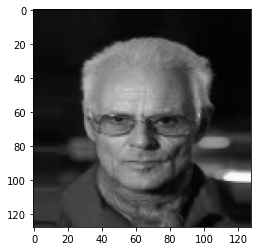

(128, 128, 3)


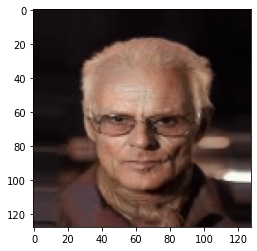

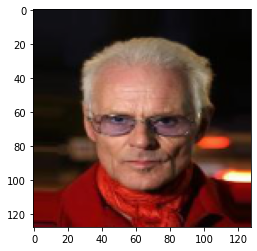

(10, 128, 128, 2)
                0             1    ...         126         127
count  1.280000e+02  1.280000e+02  ...  128.000000  128.000000
mean  -2.748456e-03 -2.748456e-03  ...    0.005724    0.004824
std    2.176925e-18  2.176925e-18  ...    0.021451    0.021632
min   -2.748456e-03 -2.748456e-03  ...   -0.030263   -0.023305
25%   -2.748456e-03 -2.748456e-03  ...   -0.004083   -0.002748
50%   -2.748456e-03 -2.748456e-03  ...   -0.002748   -0.002748
75%   -2.748456e-03 -2.748456e-03  ...    0.007304    0.002564
max   -2.748456e-03 -2.748456e-03  ...    0.073751    0.078653

[8 rows x 128 columns]
              0           1           2    ...         125         126         127
count  128.000000  128.000000  128.000000  ...  128.000000  128.000000  128.000000
mean    -0.003335   -0.000466   -0.000144  ...    0.031121    0.027624    0.023276
std      0.002643    0.003028    0.001378  ...    0.046496    0.047319    0.038728
min     -0.015053   -0.002423   -0.007742  ...   -0.014124 

In [ ]:
for i in range(10):
    print("input tensor :\n", input_tensor[i].shape)
    print("prediction :\n", prediction[i])
    print("output tensor :\n", output_tensor[i])

    input_image = np.concatenate((input_tensor[i], np.zeros((img_size, img_size, 2))), axis=2)
    input_image[:, :, 0] = input_image[:, :, 0] * 100
    input_image = color.lab2rgb(input_image)
    print(input_image.shape)
    plt.imshow(input_image, cmap='gray')
    plt.show()
    plt.imsave('/content/data//logs/'+str(i)+'_input.png', input_image)

    output_image = np.concatenate((input_tensor[i], prediction[i]), axis=2)
    output_image[:, :, 0] = output_image[:, :, 0] * 100
    output_image[:, :, 1:] = (output_image[:, :, 1:]) * 128
    output_image = color.lab2rgb(output_image)
    print(output_image.shape)

    plt.imshow(output_image)
    plt.show()
    plt.imsave('/content/data//logs/' + str(i) + '_prediction.png', output_image)

    output_image = np.concatenate((input_tensor[i], output_tensor[i]), axis=2)
    output_image[:, :, 0] = output_image[:, :, 0] * 100
    output_image[:, :, 1:] = (output_image[:, :, 1:] ) * 128

    output_image = color.lab2rgb(output_image)
    plt.imshow(output_image)
    plt.show()
    plt.imsave('/content/data//logs/' + str(i) + '_actual.png', output_image)

print(prediction.shape)
print(pd.DataFrame(data=output_tensor[0,:,:,0]).describe())
print(pd.DataFrame(data=prediction[0,:,:,0]).describe())


In [ ]:
!zip -r /content/data/logs.zip /content/data//logs

  adding: content/data//logs/ (stored 0%)
  adding: content/data//logs/8_input.png (deflated 2%)
  adding: content/data//logs/3_input.png (deflated 3%)
  adding: content/data//logs/2_actual.png (stored 0%)
  adding: content/data//logs/0_input.png (deflated 3%)
  adding: content/data//logs/4_prediction.png (stored 0%)
  adding: content/data//logs/5_input.png (deflated 2%)
  adding: content/data//logs/7_input.png (deflated 1%)
  adding: content/data//logs/7_actual.png (stored 0%)
  adding: content/data//logs/8_prediction.png (stored 0%)
  adding: content/data//logs/9_prediction.png (stored 0%)
  adding: content/data//logs/2_prediction.png (stored 0%)
  adding: content/data//logs/1_actual.png (stored 0%)
  adding: content/data//logs/8_actual.png (deflated 0%)
  adding: content/data//logs/5_prediction.png (deflated 0%)
  adding: content/data//logs/3_prediction.png (deflated 0%)
  adding: content/data//logs/6_prediction.png (stored 0%)
  adding: content/data//logs/0_prediction.png (stored 0